In [1]:
import openai
import os
import json
import re
import requests
import pandas as pd
import tiktoken
import stanza 
import tqdm.notebook as tq
from pydantic import BaseModel, Field
from typing import Optional, List
import concurrent.futures
import time
import ast
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\ProgramData\anaconda3\envs\business\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#user openai token
OPENAI_KEY = input()

In [2]:
client = openai.OpenAI(
    api_key= OPENAI_KEY
)

# Simple prompt tests

In [3]:
class Prompt():

    def __init__(self, word, from_language = "Spanish", to_language = "English"):
        self.text = """
Instruction:
You get a {from_language} word. You need to prepare its dictionary entry. List its possible translations to {to_language}. List as much translations as possible, preferrably all of them. Order the list in descending order of likelihood (commonness) of translation. After each word indicate the part of speech as it is done in dictionaries. Then provide two different sentences in {from_language} in which the words are used and their translations to {to_language}. 
if the word has several translations, the example sentences should employ different meanings of the word. Leave no additional comment. Do not include translations of the sentences to English. If you can not translate a word, return empty strings.

Example:
input word: trabajo
'translation': 'work (noun); job (noun); to work (noun)',
 'example_1': 'No puedo soportar cuando otros están trabajando. Voy a acostarme.',
 'example_2': 'El trabajo no es un lobo - en el bosque no se escapa.',
 'example_translation_1': 'I can't stand still when others are working. I'm going to bed.',
 'example_translation_2': 'Work is not a wolf - it does not run away in the forest.'
""".format(word = word, to_language = to_language, from_language = from_language)


        class Grammar(BaseModel):
            translation: str = Field(..., description=f"List of all possible translations of the input word from {from_language} to {to_language}.")
            example_1: str = Field(..., description=f"An example of a sentence in which the input word is used in {from_language}.")
            example_2: str = Field(..., description=f"An example of a sentence in which the input word is used in {from_language}. Should be different from example_1.")
            example_translation_1: str = Field(..., description=f"Translation of example_1 from {from_language} to {to_language}.")
            example_translation_2: str = Field(..., description=f"Translation of example_2 from {from_language} to {to_language}.")
                                        

        self.schema = Grammar.schema()

def return_entry(translation, example_1, example_2, example_translation_1, example_translation_2):
    """Get dictionary entry of a word."""
    return {"translation" : translation, "example_1" : example_1, "example_2" : example_2, "example_translation_1" : example_translation_1, "example_translation_2" : example_translation_2}


In [4]:
def get_entry(word, to_language = "English", from_language = "Spanish"):
    prompt = Prompt(word = word, to_language = to_language, from_language = from_language).text   
    chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                   messages=[{"role": "system", "content": prompt},
                                                             {"role": "user", "content": word}])
    response = chat_completion.choices[0].message.content
    return response

In [73]:
new_entry = get_entry("amigo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

'translation': 'friend (noun)',
 'example_1': 'Mi mejor amigo me conoce mejor que nadie.',
 'example_2': 'Hoy salí a caminar con mis amigos en el parque.',
 'example_translation_1': 'My best friend knows me better than anyone.',
 'example_translation_2': 'Today I went for a walk with my friends in the park.'



Token length:
83


In [74]:
new_entry = get_entry("huevo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

'translation': 'egg (noun)',
 'example_1': 'Voy a hacer una torta con tres huevos.',
 'example_2': 'Este restaurante sirve huevos revueltos con tocino.',
 'example_translation_1': 'I'm going to make a cake with three eggs.',
 'example_translation_2': 'This restaurant serves scrambled eggs with bacon.'



Token length:
81


In [75]:
new_entry = get_entry("pueblo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

'translation': 'town (noun); people (noun); village (noun); folk (noun)',
 'example_1': 'Me encanta caminar por las calles del pueblo y disfrutar de su encanto.',
 'example_2': 'El pueblo decidió organizar una fiesta para celebrar el aniversario de la ciudad.',
 'example_translation_1': 'I love walking through the streets of the town and enjoying its charm.',
 'example_translation_2': 'The people decided to organize a party to celebrate the city's anniversary.'



Token length:
115


In [76]:
new_entry = get_entry("unido")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

'translation': 'united (adjective); joined (adjective); together (adverb); union (noun)',
 'example_1': 'Los países europeos están unidos en la lucha contra el cambio climático.',
 'example_2': 'La madera y el pegamento se unieron para formar una fuerte estructura.',
 'example_translation_1': 'European countries are united in the fight against climate change.',
 'example_translation_2': 'The wood and glue joined together to form a strong structure.'



Token length:
110


In [77]:
new_entry = get_entry("habla")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

'translation': 'speak (verb); talk (verb); speech (noun); language (noun); word (noun)',
 'example_1': 'Ella habla tres idiomas diferentes.',
 'example_2': 'No puedo hablar ahora, estoy ocupado.',
 'example_translation_1': 'She speaks three different languages.',
 'example_translation_2': "I can't talk now, I'm busy."



Token length:
86


In [5]:
def get_entry_grammar(word, to_language = "English", from_language = "Spanish"):
    prompt = Prompt(word = word, to_language = to_language, from_language = from_language)   
    chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                   messages=[{"role": "system", "content": prompt.text},
                                                             {"role": "user", "content": "The word is: " + word}], 
                                                    tools = [{
            "type": "function",
            "function": {
                "name": "return_entry",
                "description": "Get dictionary entry of a word.",
                "parameters" :     prompt.schema
            }}])
    return chat_completion.choices[0].message.tool_calls[0].function.arguments

In [69]:
new_entry = get_entry_grammar("amigo")
print("Generated entry:\n")
print(new_entry)

Generated entry:

{'translation': 'friend (noun)', 'example_1': 'Mi mejor amigo está de cumpleaños hoy.', 'example_2': 'Ella es una buena amiga mía.', 'example_translation_1': 'My best friend is having a birthday today.', 'example_translation_2': 'She is a good friend of mine.'}


In [78]:
new_entry = get_entry_grammar("huevo")
print("Generated entry:\n")
print(new_entry)

Generated entry:

{'translation': 'egg (noun); testicle (noun)', 'example_1': 'Me gusta comer huevo en el desayuno.', 'example_2': 'El gallo protege sus huevos del depredador.', 'example_translation_1': 'I like to eat eggs for breakfast.', 'example_translation_2': 'The rooster protects its eggs from predators.'}


In [79]:
new_entry = get_entry_grammar("pueblo")
print("Generated entry:\n")
print(new_entry)

Generated entry:

{'translation': 'town (noun); people (noun); village (noun); folk (noun)', 'example_1': 'Vivo en un pueblo pequeño en las montañas.', 'example_2': 'El pueblo estaba emocionado por la llegada del circo.', 'example_translation_1': 'I live in a small town in the mountains.', 'example_translation_2': 'The people were excited about the arrival of the circus.'}


In [80]:
new_entry = get_entry_grammar("unido")
print("Generated entry:\n")
print(new_entry)

Generated entry:

{'translation': 'united (adjective); joined (adjective); connected (adjective)', 'example_1': 'Los países están unidos en su lucha contra el cambio climático.', 'example_2': 'Las dos partes están unidas por un acuerdo comercial.', 'example_translation_1': 'The countries are united in their fight against climate change.', 'example_translation_2': 'The two parties are joined by a trade agreement.'}


In [81]:
new_entry = get_entry_grammar("habla")
print("Generated entry:\n")
print(new_entry)

Generated entry:

{'translation': 'speak (verb); talk (verb)', 'example_1': 'Ella habla francés con fluidez.', 'example_2': 'Vamos a hablar sobre el proyecto.', 'example_translation_1': 'She speaks French fluently.', 'example_translation_2': "Let's talk about the project."}


In [5]:
def get_expensive_entry(word, to_language = "English", from_language = "Spanish"):
    prompt = Prompt(word = word).text
    chat_completion = client.chat.completions.create(model="gpt-4",
                                                   messages=[{"role": "system", "content": prompt},
                                                             {"role": "user", "content": word}])
    response = chat_completion.choices[0].message.content
    return response

In [42]:
new_entry = get_expensive_entry("amigo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

translation: friend (noun); mate (noun, informal); buddy (noun, informal)

sentences: 

1. Juan es mi mejor amigo. 
2. ¡Oye, amigo! ¿Cómo has estado?

English translation:

1. John is my best friend.
2. Hey mate! How have you been?



Token length:
65


In [43]:
new_entry = get_expensive_entry("huevo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

translation: egg (noun); testicle (slang noun)

sentences: 
1. Necesito tres huevos para hacer esta tortilla. 
2. Después de ser golpeado en los huevos, le dolió durante varios días. 

translation to English:
1. I need three eggs to make this omelette. 
2. After being hit in the testicles, he felt pain for several days.



Token length:
90


In [44]:
new_entry = get_expensive_entry("pueblo")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

translation: people (noun); town (noun); village (noun); folk (noun)

sentences: 

1. La gente de este pueblo es muy amable.
2. Mi pueblo natal es tranquilo y hermoso.

translations:

1. The people in this town are very friendly.
2. My hometown is quiet and beautiful.



Token length:
70


In [45]:
new_entry = get_expensive_entry("unido")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

translation: united (adjective); joined (adjective); attached (adjective); combined (adjective)

sentences: 
1. Los estados unidos son un país en América del Norte. 
2. Los dos países están unidos por una causa común.

translation: 
1. The United States are a country in North America. 
2. The two countries are united by a common cause.



Token length:
83


In [46]:
new_entry = get_expensive_entry("habla")
print("Generated entry:\n")
print(new_entry)
print("\n\n\nToken length:")
print(len(enc.encode(new_entry)))

Generated entry:

translation: speech (noun); language (noun); talk (verb); speaking (noun); speak (verb)

sentences: 
1. Su habla es muy fluida y clara. 
2. El comportamiento de una persona dice más que su habla.

Translation:
1. His/her speech is very fluent and clear.
2. A person's behavior says more than their language.



Token length:
80


# Lemmas list preparation

In [44]:
with open("source_list//wordlist.json", "r") as f:
    word_frequencies = json.load(f)

In [65]:
wordfreq = pd.DataFrame({"word" : word_frequencies.keys(), "freq" : word_frequencies.values()})

In [4]:
import string
# Sample DataFrame
data = {'Column_with_strings': ['AbcDef', 'Hello, World!', 'NoCapsHere', 'Str!ngWithPunct', 'ConsonantCheck', 'Héroes', 'Árbol']}
df = pd.DataFrame(data)

# Function to filter strings based on specified conditions
def custom_filter(mystring):
    # Check for a capitalized letter not in the first position
    condition1 = any(char.isupper() and index != 0 for index, char in enumerate(mystring))

    # Check for punctuation
    condition2 = any(char in string.punctuation for char in mystring)

    # Check for 4 or more consecutive consonants (including Spanish characters)
    condition3 = bool(re.search(r"[^aeiouáéíóúüAEIOUÁÉÍÓÚÜ]{4,}", mystring))

    return not (condition1 or condition2 or condition3)

# Apply the custom filter to the DataFrame
filtered_df = df[df['Column_with_strings'].apply(custom_filter)]

print(filtered_df)

  Column_with_strings
5              Héroes
6               Árbol


In [66]:
wordfreq = wordfreq.sort_values("freq", ascending = False)
wordfreq = wordfreq[~wordfreq.word.str.contains(r'[0-9]')]
wordfreq = wordfreq[wordfreq["word"].apply(custom_filter)]
wordfreq = wordfreq[~wordfreq['word'].apply(lambda x: x[0].isupper())]
wordfreq_top = wordfreq.head(500000)

In [67]:
wordfreq

,word,freq
1359106,de,74710336
986998,la,36800428
565730,el,31538622
458717,en,30624538
1816066,que,25098939
...,...,...
1407323,hroamjos,1
1407380,trayectio,1
1407393,megviaesbit,1
1407383,dipersó,1


In [7]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2024-01-17 11:50:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-17 11:50:34 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |

2024-01-17 11:50:34 INFO: Using device: cpu
2024-01-17 11:50:34 INFO: Loading: tokenize
2024-01-17 11:50:35 INFO: Loading: mwt
2024-01-17 11:50:35 INFO: Loading: pos
2024-01-17 11:50:35 INFO: Loading: lemma
2024-01-17 11:50:35 INFO: Done loading processors!


In [8]:
buckets = [i * 100 for i in range(round(len(wordfreq.word) / 100))]
buckets.append(len(wordfreq.word))

In [9]:
wordfreq_list = wordfreq.word.tolist()

In [10]:
all_lemmas = []
for bucket_up in tq.tqdm(list(buckets[1:])):
    new_lemmas_bucket = nlp(" ".join(wordfreq_list[bucket_up - 100:bucket_up]))
    for i in new_lemmas_bucket.sentences[0].words:
        all_lemmas.append({"lemma" : i.lemma, "word" : i.text, "pfspeech" : i.upos})

  0%|          | 0/8349 [00:00<?, ?it/s]

In [63]:
all_lemmas_df = pd.DataFrame(all_lemmas)
all_lemmas_df = all_lemmas_df[~all_lemmas_df.pfspeech.isin(["PUNCT", "PROPN"])]
all_lemmas_df = all_lemmas_df.drop_duplicates(["lemma", "word"])

In [71]:
all_lemmas_df

,lemma,word,pfspeech
0,de,de,ADP
1,el,la,DET
2,el,el,DET
3,en,en,ADP
4,que,que,PRON
...,...,...,...
879568,<unk>esconder,<UNK>esconder,VERB
879571,atributobien,atributobien,NOUN
879584,vateral,vaterales,NOUN
879683,hroamjo,hroamjos,NOUN


In [68]:
wordfreq = wordfreq.merge(all_lemmas_df, on = "word", how = "inner")

In [4]:
wordfreq_clean = wordfreq[["freq", "lemma"]].groupby("lemma").sum().reset_index()

In [5]:
lemma_frequency = wordfreq_clean.sort_values("freq", ascending = False)

In [6]:
lemma_frequency.head(200000)

,lemma,freq
90270,de,74710336
118048,el,36800428
121940,en,30624538
279721,que,25098939
0,a,21724303
...,...,...
257377,pfepfajat,2
257376,pfeogmab,2
92118,deeld,2
257370,pfemjat,2


# Check word function testing

In [1]:
#uses ~50 tokens
def check_word(word, to_language):
    chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                   messages=[{"role": "system", "content": f"You are a specialist in {to_language} dictionaries."},
                                                             {"role": "user", "content": f"Is {word} a legit, correctly spelled Spanish word? Answer strictly 'Yes' or 'No'. Do not provide any explanation."}]
                )
    answer = chat_completion.choices[0].message.content
    if "yes" in answer.lower():
        return True
    else:
        chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                       messages=[{"role": "system", "content": f"You are a specialist in {to_language} dictionaries."},
                                                                 {"role": "user", "content": f"Is {word} a legit, correctly spelled Spanish word? Answer strictly 'Yes' or 'No'. Do not provide any explanation."}]
                    )
        answer = chat_completion.choices[0].message.content
        if "no" in answer.lower():
            return False
        else:
            return True

In [8]:
#uses ~50 tokens
def spelling(word, to_language):
    chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                   messages=[{"role": "system", "content": f"You are a specialist in {to_language} dictionaries."},
                                                             {"role": "user", "content": f"Correct any spelling errors in the following {to_language} word: {word}. If there are no errors, do not change anything. Return corrected word. If the word is not close to any existing word, return 'Not a word'. Do not provide any explanation."}]
                )

    answer = chat_completion.choices[0].message.content

    stop_counter = 0
    while (len(answer.split(" ")) > 2) and (answer != "Not a word") and (stop_counter < 1):
        stop_counter += 1
        chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                       messages=[{"role": "system", "content": f"You are a specialist in {to_language} dictionaries."},
                                                                 {"role": "user", "content": f"Correct any spelling errors in the following {to_language} word: {word}. If there are no errors, do not change anything. Return corrected word. If the word is not close to any existing word, return 'Not a word'. Do not provide any explanation. It is important to return only one word or 'Not a word'!"}]
                    )
        answer = chat_completion.choices[0].message.content
    return answer


In [36]:
check_word("objetivosro", "Spanish")

False

In [71]:
spelling("funcionamietno", "Spanish")

'funcionamiento'

In [54]:
spelling("amwcqsr", "Spanish")

'Not a word'

In [63]:
# %%time
normal_counter = 0
for word in normal_words:
    cor = spelling(word, "Spanish")
    print(word, cor)
    if cor == word:
        normal_counter += 1
bullshit_counter = 0
for word in bullshit_words:
    cor = spelling(word, "Spanish")
    print(word, cor)
    if cor == word:
        bullshit_counter += 1

cada cada
buena buena
me me
dar No errors.
nuestro nuestro
bajo bajo
nombre nombre
muy muy
través través
sólo solo
forma forma
frase frase
gran gran
pensar pensar
decir No errors.
ayudar ayudar
bajo bajo
línea línea
distinto distinto
vez vez
causa causa
ccada cada
buna buena
msdce Not a word
dscar descar
asdc Not a word
ddd Not a word
nomccbre nombre
asfa Not a word
kghk Not a word.
sóo sol
fompja Not a word.
frse frse
gasscn Not a word
pendssar pensar
accd No changes: accd
awda agua
cddaAA cdaa
vdsvqre Not a word
iuytr Not a word
bbbdfga Not a word
cagusa casusa


In [64]:
normal_counter

18

In [65]:
bullshit_counter

1

# Clean lemmas list

In [ ]:
def split_list(lemmas_list, chunk_size = 600): 
    chunks = list()
    num_chunks = len(lemmas_list) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(lemmas_list[i*chunk_size:(i+1)*chunk_size])
    return chunks

lemma_chunks = split_list(lemma_frequency.lemma.tolist()[:100000])

In [ ]:
%%time
def split_list(lemmas_list, chunk_size = 600): 
    chunks = list()
    num_chunks = len(lemmas_list) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(lemmas_list[i*chunk_size:(i+1)*chunk_size])
    return chunks

lemma_chunks = split_list(lemmas_list)

spelling_checked_words = []
def check_call(word):
    spelling_checked_words.append({"word" : word, "spelling" : spelling(word, "Spanish")})

        
def parallel_openai_requests(prompts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(check_call, prompts))

    return results

for chunk in tq.tqdm(lemma_chunks):
    start = time.time()
    parallel_openai_requests(chunk)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

In [15]:
spelling_checked_words

[{'word': 'entre', 'spelling': 'entre'},
 {'word': 'ser', 'spelling': 'ser'},
 {'word': 'uno', 'spelling': 'uno'},
 {'word': 'como', 'spelling': 'como'},
 {'word': 'este', 'spelling': 'este'},
 {'word': 'decir', 'spelling': 'decir'},
 {'word': 'a', 'spelling': 'Not a word'},
 {'word': 'dos', 'spelling': 'dos'},
 {'word': 'presidente', 'spelling': 'presidente'},
 {'word': 'y', 'spelling': 'Not a word'},
 {'word': 'que', 'spelling': 'que'},
 {'word': 'de', 'spelling': 'de'},
 {'word': 'sobre', 'spelling': 'sobre'},
 {'word': 'con', 'spelling': 'con'},
 {'word': 'en', 'spelling': 'en'},
 {'word': 'no', 'spelling': 'no'},
 {'word': 'para', 'spelling': 'para'},
 {'word': 'su', 'spelling': 'su'},
 {'word': 'por', 'spelling': 'por'},
 {'word': 'al', 'spelling': 'al'},
 {'word': 'más', 'spelling': 'más'},
 {'word': 'el', 'spelling': 'el'},
 {'word': 'millón', 'spelling': 'millón'},
 {'word': 'desde', 'spelling': 'desde'},
 {'word': 'pero', 'spelling': 'pero'},
 {'word': 'él', 'spelling': 'él'}

In [17]:
catch_up_lemmas = []
checked_words = pd.DataFrame(spelling_checked_words).word.tolist()
for i in lemma_frequency.lemma.tolist()[:100000]:
    if i not in checked_words:
        catch_up_lemmas.append(i)

catch_up_lemma_chunks = split_list(catch_up_lemmas)

In [24]:
%%time
def check_call(word):
    spelling_checked_words.append({"word" : word, "spelling" : spelling(word, "Spanish")})

        
def parallel_openai_requests(prompts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the function over the list of prompts in parallel
        results = list(executor.map(check_call, prompts))

    return results

for chunk in tq.tqdm(catch_up_lemma_chunks):
    start = time.time()
    parallel_openai_requests(chunk)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

  0%|          | 0/63 [00:00<?, ?it/s]

CPU times: total: 3min 17s
Wall time: 1h 45min 57s


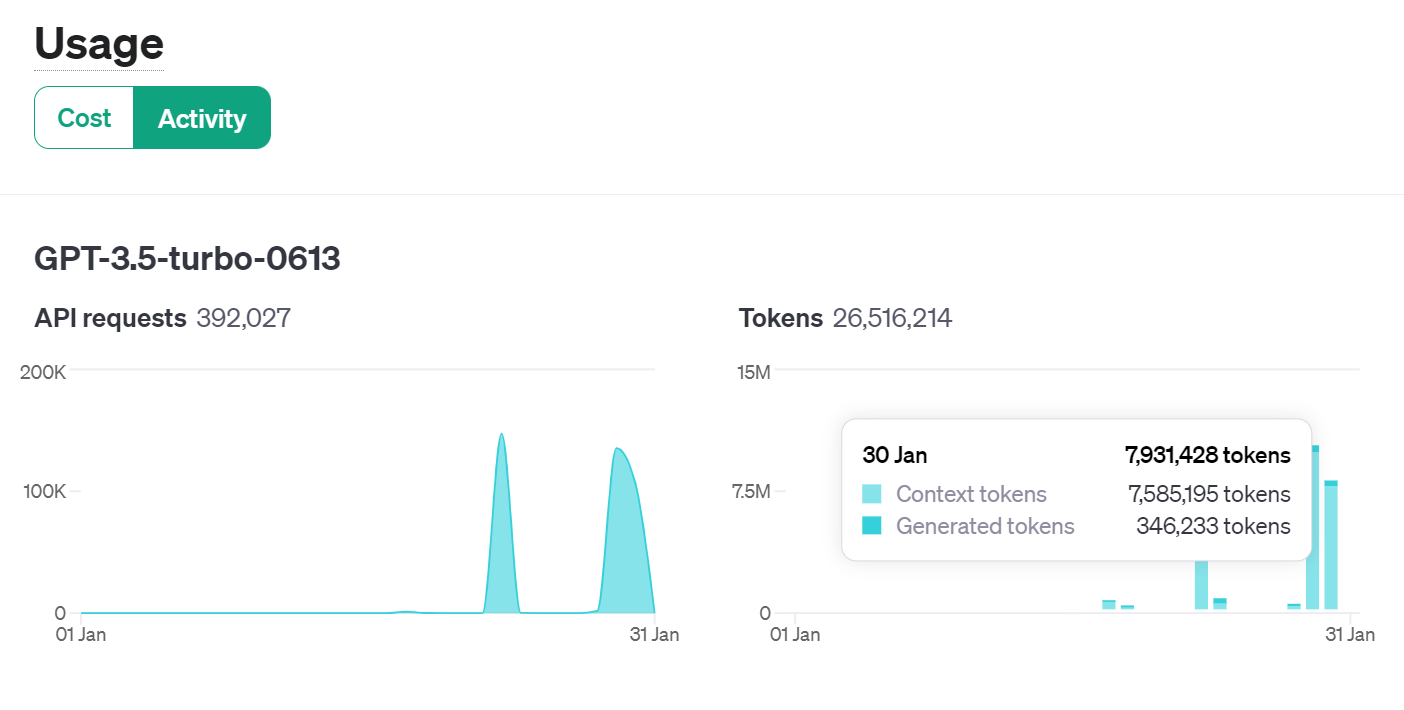
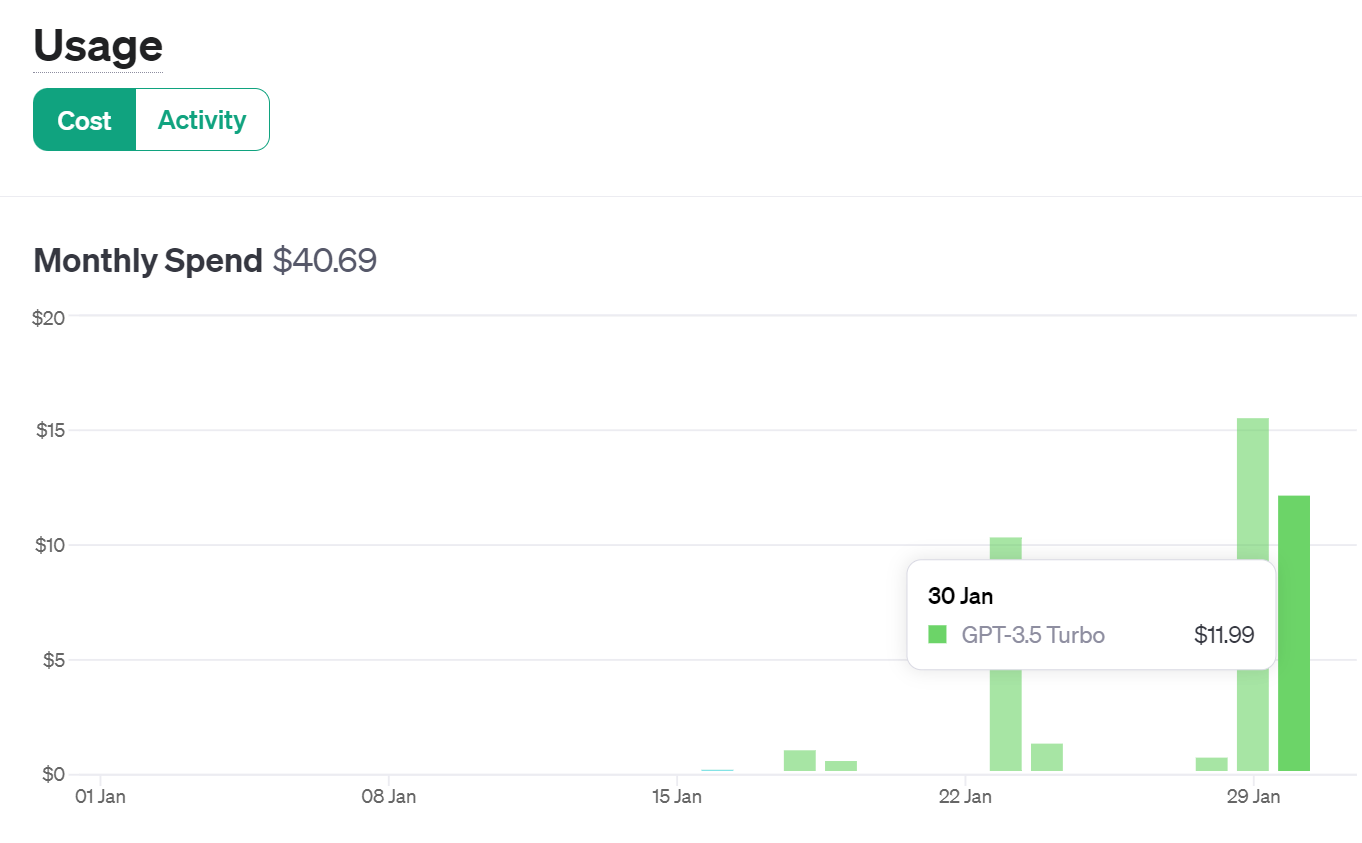

In [25]:
len(spelling_checked_words)

101200

In [8]:
spelling_checked_words = pd.DataFrame(spelling_checked_words)

In [9]:
spelling_checked_words['spelling_words_num'] = spelling_checked_words['spelling'].str.split(" ").apply(len)

In [11]:
spelling_checked_words[spelling_checked_words.spelling_words_num > 1].spelling.value_counts().sum()

18203

In [32]:
spelling_checked_words[spelling_checked_words.spelling_words_num > 1].spelling.value_counts().tail(50)

spelling
ad valorem                                                                                                                                                        1
hoy martes                                                                                                                                                        1
derecho cerrador                                                                                                                                                  1
art déco                                                                                                                                                          1
derecho dominicano                                                                                                                                                1
oeste centro                                                                                                                                                      1
zona ta

In [10]:
spelling_checked_words[spelling_checked_words.spelling_words_num > 1].spelling.value_counts().head(20)

spelling
Not a word                   16353
No errors.                     488
No errors                      102
Not a word.                     38
No changes needed.              25
No errors found.                18
No word                         14
No corrections needed.          11
No suggestions.                 10
No changes.                      8
No spelling errors.              4
No word.                         4
No spelling errors found.        3
No suggestions                   3
'Not a word'                     3
miércoles informó                3
No changes necessary.            3
concierto homenaje               3
de facto                         3
después de                       3
Name: count, dtype: int64

In [39]:
no_corrections = ["No errors." , "No errors" , "No changes needed.", "No corrections needed",
                                         "No errors found." , "No changes." , "No spelling errors.", "No changes necessary.", 
                 "No cambios", "No correction"]
spelling_checked_words.loc[spelling_checked_words.spelling.isin(no_corrections), "spelling"] = spelling_checked_words.word
for word in no_corrections:
    spelling_checked_words.loc[spelling_checked_words.spelling.str.contains(word.replace(".", "")), "spelling"] = spelling_checked_words.word

In [23]:
spelling_checked_words[spelling_checked_words.spelling_words_num > 1].spelling.value_counts().head(20)

spelling
Not a word            16353
Not a word.              38
No word                  14
No suggestions.          10
No word.                  4
conferencia debate        3
después de                3
de facto                  3
concierto homenaje        3
miércoles informó         3
No suggestions            3
'Not a word'              3
No es una palabra.        2
vigésima tercera          2
No cambios.               2
lconcd                    2
vigésimo séptimo          2
árabe musulmán            2
trigésima segunda         2
por qué                   2
Name: count, dtype: int64

In [25]:
spelling_checked_words

,word,spelling,spelling_words_num
0,entre,entre,1
1,ser,ser,1
2,uno,uno,1
3,como,como,1
4,este,este,1
...,...,...,...
101195,debu,debe,1
101196,dlaccn,Not a word,3
101197,epaf,Not a word,3
101198,hiperrealidad,hiperrealidad,1


In [ ]:
not_a_word = ["Not a word.",
 "No word",
 "No suggestions.",
 "No es una palabra",
 "No word.",
 "No a word",
 "No existing word.",
              "No suggestion",
              "No existe"
             ]
not_a_word_dict = {word : "Not a word" for word in not_a_word}
not_a_word_dict

for word in not_a_word:
    spelling_checked_words.loc[spelling_checked_words.spelling.str.contains(word.replace(".", "")), "spelling"] = "Not a word"

In [40]:
# spelling_checked_words = spelling_checked_words.spelling.replace({"Not a word." : "Not a word", "No word" : "Not a word", "No suggestions." : "Not a word",
#                                          "No es una palabra" : "Not a word", "No word." : "Not a word", "No a word" : "Not a word",
#                                          "No existing word." : "Not a word"})
spelling_checked_words[spelling_checked_words.spelling_words_num > 1].spelling.value_counts().head(20)

spelling
Not a word            16485
miércoles informó         3
después de                3
de facto                  3
concierto homenaje        3
conferencia debate        3
trigésima segunda         2
vigésimo cuarto           2
casas habitación          2
vigésimo primero          2
vóley playa               2
vigésimo séptimo          2
enero septiembre          2
liberal sandinista        2
el último                 2
atentado suicida          2
trigésima tercera         2
vigésima tercera          2
árabe musulmán            2
policía militar           2
Name: count, dtype: int64

In [30]:
spelling_checked_words[spelling_checked_words.spelling == "miércoles informó"]

,word,spelling,spelling_words_num
62627,miércolesinformó,miércoles informó,2
63229,miércolesinformó,miércoles informó,2
63827,miércolesinformó,miércoles informó,2


In [31]:
spelling_checked_words[spelling_checked_words.spelling == "de facto"]

,word,spelling,spelling_words_num
62823,defacto,de facto,2
63433,defacto,de facto,2
64019,defacto,de facto,2


In [76]:
def extract_string(input_string):
    if "->" in input_string:
        return input_string.split("-> ")[-1]
    else:
        return input_string

0                        entre
1                          ser
2                          uno
3                         como
4                         este
                  ...         
101192                cabrillo
101193                  cableó
101194    europeo-sudamericano
101198           hiperrealidad
101199              distituido
Name: spelling, Length: 59888, dtype: object

In [78]:
spelling_checked_words["spelling"] = spelling_checked_words.spelling.apply(extract_string)

C:\Users\Ivand\AppData\Local\Temp\ipykernel_24212\464225049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spelling_checked_words["spelling"] = spelling_checked_words.spelling.apply(extract_string)


In [80]:
spelling_checked_words = spelling_checked_words.drop_duplicates("spelling")

In [81]:
spelling_checked_words.to_excel("spelling_checked_words_clean.xlsx")

# Accuracy test

## Sample

In [46]:
accuracy_test_lemmas_high = spelling_checked_words.spelling.sample(400, random_state = 1).tolist()
accuracy_test_lemmas_medium = lemma_frequency.iloc[100000:200000].sample(800, random_state = 1).lemma.tolist()
accuracy_test_lemmas_low = lemma_frequency.iloc[200000:300000].sample(800, random_state = 1).lemma.tolist()

In [49]:
accuracy_test_lemmas_medium_new = []
for word in tq.tqdm(accuracy_test_lemmas_medium):
    accuracy_test_lemmas_medium_new.append({"word" : word, "spelling" : spelling(word, "Spanish")})

  0%|          | 0/800 [00:00<?, ?it/s]

In [50]:
accuracy_test_lemmas_medium_df = pd.DataFrame(accuracy_test_lemmas_medium_new)
no_corrections = ["No errors." , "No errors" , "No changes needed.", "No corrections needed",
                                         "No errors found." , "No changes." , "No spelling errors.", "No changes necessary.", 
                 "No cambios", "No correction"]
accuracy_test_lemmas_medium_df.loc[accuracy_test_lemmas_medium_df.spelling.isin(no_corrections), "spelling"] = accuracy_test_lemmas_medium_df.word
for word in no_corrections:
    accuracy_test_lemmas_medium_df.loc[accuracy_test_lemmas_medium_df.spelling.str.contains(word.replace(".", "")), "spelling"] = accuracy_test_lemmas_medium_df.word

In [51]:
not_a_word = ["Not a word.",
 "No word",
 "No suggestions.",
 "No es una palabra",
 "No word.",
 "No a word",
 "No existing word.",
              "No suggestion",
              "No existe"
             ]
not_a_word_dict = {word : "Not a word" for word in not_a_word}
not_a_word_dict

for word in not_a_word:
    accuracy_test_lemmas_medium_df.loc[accuracy_test_lemmas_medium_df.spelling.str.contains(word.replace(".", "")), "spelling"] = "Not a word"

In [53]:
accuracy_test_lemmas_medium_df = accuracy_test_lemmas_medium_df.drop_duplicates("spelling")
accuracy_test_lemmas_medium_df = accuracy_test_lemmas_medium_df[accuracy_test_lemmas_medium_df['spelling'] != "Not a word"]

In [54]:
accuracy_test_lemmas_medium_df

,word,spelling
0,industrialesfinancieros,industriales financieros
1,afirmbar,afirmar
2,extrememo,extremo
3,cerrilla,cerrillas
4,recalacar,recalcar
...,...,...
794,relaci,relación
795,almotamarnet,almotamarnet
797,uiguro,uiguro
798,neurofisiólogo,neurofisiólogo


In [85]:
accuracy_test_lemmas_medium_df['spelling'] = accuracy_test_lemmas_medium_df.spelling.apply(extract_string)

In [86]:
accuracy_test_lemmas_medium = accuracy_test_lemmas_medium_df.spelling.tolist()

In [58]:
accuracy_test_lemmas_low_new = []
for word in tq.tqdm(accuracy_test_lemmas_low):
    accuracy_test_lemmas_low_new.append({"word" : word, "spelling" : spelling(word, "Spanish")})

  0%|          | 0/800 [00:00<?, ?it/s]

In [59]:
accuracy_test_lemmas_low_df = pd.DataFrame(accuracy_test_lemmas_low_new)
no_corrections = ["No errors." , "No errors" , "No changes needed.", "No corrections needed",
                                         "No errors found." , "No changes." , "No spelling errors.", "No changes necessary.", 
                 "No cambios", "No correction"]
accuracy_test_lemmas_low_df.loc[accuracy_test_lemmas_low_df.spelling.isin(no_corrections), "spelling"] = accuracy_test_lemmas_low_df.word
for word in no_corrections:
    accuracy_test_lemmas_low_df.loc[accuracy_test_lemmas_low_df.spelling.str.contains(word.replace(".", "")), "spelling"] = accuracy_test_lemmas_low_df.word

In [60]:
not_a_word = ["Not a word.",
 "No word",
 "No suggestions.",
 "No es una palabra",
 "No word.",
 "No a word",
 "No existing word.",
              "No suggestion",
              "No existe"
             ]
not_a_word_dict = {word : "Not a word" for word in not_a_word}
not_a_word_dict

for word in not_a_word:
    accuracy_test_lemmas_low_df.loc[accuracy_test_lemmas_low_df.spelling.str.contains(word.replace(".", "")), "spelling"] = "Not a word"

In [61]:
accuracy_test_lemmas_low_df = accuracy_test_lemmas_low_df.drop_duplicates("spelling")
accuracy_test_lemmas_low_df = accuracy_test_lemmas_low_df[accuracy_test_lemmas_low_df['spelling'] != "Not a word"]

In [82]:
accuracy_test_lemmas_low_df['spelling'] = accuracy_test_lemmas_low_df.spelling.apply(extract_string)

In [83]:
accuracy_test_lemmas_low_df

,word,spelling
0,auotestima,autoestima
2,correspoindiente,correspondiente
3,nheengatu,nhe'engatu
4,aparicionista,aparicionista
8,juriscción,jurisdicción
...,...,...
794,terraciada,terrazada
795,ternin,termín
796,epedimeia,epidemia
797,silabeando,silabeando


In [84]:
accuracy_test_lemmas_low = accuracy_test_lemmas_low_df.spelling.tolist()

In [87]:
accuracy_test_lemmas_low

['autoestima',
 'correspondiente',
 "nhe'engatu",
 'aparicionista',
 'jurisdicción',
 'prosterno',
 'torero',
 'internarma',
 'verdeamarela',
 'sobrecuello',
 'incansar',
 'antieducación',
 'antihegemonismo',
 'traumatización',
 'adolescente',
 'incendiando',
 'expresar',
 'alambarda',
 'gradualmente',
 'salarial',
 'estadonunidense',
 'numerorosa',
 'constitucionalidad',
 'desapó',
 'tomaronmedida',
 'alambre',
 'desencuadernado',
 'escobrón',
 'jote',
 'bisutéro',
 'surcoreano',
 'desencabello',
 'nacional',
 'desaparecer',
 'presuigo',
 'derramamiento local',
 'padecer',
 'apendicitomía',
 'riguroso',
 'suspendo',
 'subconjuntival',
 'desempalancamiento',
 'celebridad',
 'modificado',
 'tortuga',
 'antracótero',
 'furgoneta',
 'entrelazado',
 'linda',
 'macroeconomica',
 'documentada pero',
 'sireve',
 'hermano',
 'avisémoselo',
 'rosadito',
 'reticencia',
 'escribidlo',
 'llegando',
 'calitativo',
 'aparición',
 'a la izquierda',
 'veinticinco',
 'banderizo',
 'izquierda ilegalment

In [89]:
with open("test_lemmas_low.json", "w") as f:
    json.dump(accuracy_test_lemmas_low, f)

In [90]:
with open("test_lemmas_medium.json", "w") as f:
    json.dump(accuracy_test_lemmas_medium, f)

In [91]:
with open("test_lemmas_high.json", "w") as f:
    json.dump(accuracy_test_lemmas_high, f)

## Benchmark response generation

In [9]:
with open("test_lemmas_low.json", "r") as f:
    accuracy_test_lemmas_low = json.load(f)
with open("test_lemmas_medium.json", "r") as f:
    accuracy_test_lemmas_medium = json.load(f)
with open("test_lemmas_high.json", "r") as f:
    accuracy_test_lemmas_high = json.load(f)

In [10]:
yapi_address = "https://translate.api.cloud.yandex.net/translate/v2/translate"
#Yandex API user token
IAM_TOKEN = input()

In [11]:
def yapi_translation(word):

    x = requests.post(yapi_address, json = {
      "sourceLanguageCode": "es",
      "targetLanguageCode": "en",
      "format": "PLAIN_TEXT",
        "folderId" : folder_ID, 
      "texts": [
        word
      ],
      "speller": True
    }, 
                     headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer {0}".format(IAM_TOKEN)
    })
    return x.text

In [12]:
word = "kilogramosfuerza"
x = requests.post(yapi_address, json = {
  "sourceLanguageCode": "es",
  "targetLanguageCode": "en",
  "format": "PLAIN_TEXT",
    "folderId" : folder_ID, 
  "texts": [
    word
  ],
  "speller": False
    
}, 
                 headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer {0}".format(IAM_TOKEN)
})
x.text

'{\n "translations": [\n  {\n   "text": "kilogramesforce"\n  }\n ]\n}\n'

In [13]:
%%time
price_test_translations = []
errors = []
for lemma in tq.tqdm(accuracy_test_lemmas_high):
    try:
        price_test_translations.append({"cohort" : "upper", "word" : lemma, "translation" : yapi_translation(lemma)})
    except Exception as e:
        errors.append({"cohort" : "upper", "word" : lemma, "entry" : str(e)})
for lemma in tq.tqdm(accuracy_test_lemmas_medium):
    try:
        price_test_translations.append({"cohort" : "medium", "word" : lemma, "translation" : yapi_translation(lemma)})
    except Exception as e:
        errors.append({"cohort" : "medium", "word" : lemma, "entry" : str(e)})
for lemma in tq.tqdm(accuracy_test_lemmas_low):
    try:
        price_test_translations.append({"cohort" : "low", "word" : lemma, "translation" : yapi_translation(lemma)})
    except Exception as e:
        errors.append({"cohort" : "low", "word" : lemma, "entry" : str(e)})

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

CPU times: total: 1min 54s
Wall time: 11min 17s


In [15]:
for entry in price_test_translations:
    entry['translation'] = ast.literal_eval(entry['translation'])

In [16]:
for entry in price_test_translations:
    entry['translation'] = entry['translation']['translations'][0]['text']

In [17]:
price_test_translations = pd.DataFrame(price_test_translations)

In [19]:
price_test_translations.to_excel("test_tables//yapi_translations.xlsx")

## Bunch response generation

In [4]:
from jsonschema import validate


def validate_output_error(model_response, bunch_size):
    schema = {
        "type" : "object",
        "properties" : {
           f"word_entry_{n}": {
          "type": "object",
          "properties": {
            "translation": {
              "type": "string"
            },
            "example_1": {
              "type": "string"
            },
            "example_2": {
              "type": "string"
            },
            "example_translation_1": {
              "type": "string"
            },
            "example_translation_2": {
              "type": "string"
            }
          },
          "required": [
            "translation",
            "example_1",
            "example_2",
            "example_translation_1",
            "example_translation_2"
          ]
        } for n in range(1, bunch_size + 1)
        }
    }
    if type(model_response) == str:
        model_response = ast.literal_eval(model_response)
    validate(instance = model_response, schema=schema)
    return model_response

def validate_output_bool(model_response, bunch_size):
    schema = {
        "type" : "object",
        "properties" : {
           f"word_entry_{n}": {
          "type": "object",
          "properties": {
            "translation": {
              "type": "string"
            },
            "example_1": {
              "type": "string"
            },
            "example_2": {
              "type": "string"
            },
            "example_translation_1": {
              "type": "string"
            },
            "example_translation_2": {
              "type": "string"
            }
          },
          "required": [
            "translation",
            "example_1",
            "example_2",
            "example_translation_1",
            "example_translation_2"
          ]
        } for n in range(1, bunch_size + 1)
        }
    }
    if type(model_response) == str:
        model_response = ast.literal_eval(model_response)
    try:
        validate(instance = model_response, schema=schema)
        return True
    except Exception as e:
        return False

def extract_fields(entry, field):
    entries_list = []
    for word_entry in entry:
        entries_list.append(entry[word_entry][field].replace(",", ";"))
    return entries_list

def validate_empty_translations(model_response):
    if type(model_response) == str:
        model_response = ast.literal_eval(model_response)
        translations = extract_fields(model_response, "translation")
        translations = "".join(translations)
        if translations == "":
            return False
        else:
            return True

In [5]:
from pydantic import conlist 

class PromptMultiple():

    def __init__(self, words, from_language = "Spanish", to_language = "English"):
        ex1 = """{'translation': 'work (noun); job (noun); to work (noun)',
 'example_1': 'No puedo soportar cuando otros están trabajando. Voy a acostarme.',
 'example_2': 'El trabajo no es un lobo - en el bosque no se escapa.',
 'example_translation_1': 'I can't stand still when others are working. I'm going to bed.',
 'example_translation_2': 'Work is not a wolf - it does not run away in the forest.'}"""
        ex2 = """{'translation': 'new (adj)',
 'example_1': 'Mira como un carnero a la nueva puerta.',
 'example_2': 'Una nueva escoba barre en una nueva.',
 'example_translation_1': 'Look like a ram at the new door.',
 'example_translation_2': 'A new broom sweeps as a new one.'}"""
        self.text = """
Instruction:
You get a sequence of {from_language} words: {words}. You need to prepare their dictionary entries. List their possible translations to {to_language}. List as much translations as possible, preferrably all of them. Order the list in descending order of likelihood (commonness) of translation. After each word indicate the part of speech as it is done in dictionaries (in {from_language}, please!). Then provide two different sentences in {from_language} in which the words are used and their translations to {to_language}. 
if the word has several translations, the example sentences should employ different meanings of the word. Leave no additional comment. Do not include translations of the sentences to English. If you can not translate a word, return empty strings for this particular word only.
Return a valid JSON to pass into a function for preparing dictionary entries. JSON must include an entry for each word in a sequence.
The format is the following: {{"word_entry_1" : {{"translation" : "", "example_1" : "", "example_2" : "", "example_translation_1" : "", "example_translation_2" : ""}}, ..., "word_entry_n" : {{"translation" : "", "example_1" : "", "example_2" : "", "example_translation_1" : "", "example_translation_2" : ""}}}} for each of N words in a sequence. Ensure that the format is followed.
Example:
[user input]: ["trabajo", "nuevo"]
[your response]:
"word_entry_1" : {ex1},
"word_entry_2" : {ex2}
""".format(to_language = to_language, from_language = from_language, ex1 = ex1, ex2 = ex2, words = str(words))
        
        class WordEntry(BaseModel):
            translation: str = Field(..., description=f"List of all possible translations of the input word from {from_language} to {to_language}.")
            example_1: str = Field(..., description=f"An example of a sentence in which the input word is used in {from_language}.")
            example_2: str = Field(..., description=f"An example of a sentence in which the input word is used in {from_language}. Should be different from example_1.")
            example_translation_1: str = Field(..., description=f"Translation of example_1 from {from_language} to {to_language}.")
            example_translation_2: str = Field(..., description=f"Translation of example_2 from {from_language} to {to_language}.")
        class Grammar(BaseModel):
            word_entry_1: WordEntry = Field(..., description = f"Dictionary entry for {words[0]}")
            word_entry_2: WordEntry = Field(..., description = f"Dictionary entry for {words[1]}")
            word_entry_3: WordEntry = Field(..., description = f"Dictionary entry for {words[2]}")
            word_entry_4: WordEntry = Field(..., description = f"Dictionary entry for {words[3]}")
            word_entry_5: WordEntry = Field(..., description = f"Dictionary entry for {words[4]}")
            word_entry_6: WordEntry = Field(..., description = f"Dictionary entry for {words[5]}")
            word_entry_7: WordEntry = Field(..., description = f"Dictionary entry for {words[6]}")
            word_entry_8: WordEntry = Field(..., description = f"Dictionary entry for {words[7]}")
            word_entry_9: WordEntry = Field(..., description = f"Dictionary entry for {words[8]}")
            word_entry_10: WordEntry = Field(..., description = f"Dictionary entry for {words[9]}")
            word_entry_11: WordEntry = Field(..., description = f"Dictionary entry for {words[10]}")
            word_entry_12: WordEntry = Field(..., description = f"Dictionary entry for {words[11]}")
            word_entry_13: WordEntry = Field(..., description = f"Dictionary entry for {words[12]}")
            word_entry_14: WordEntry = Field(..., description = f"Dictionary entry for {words[13]}")
            word_entry_15: WordEntry = Field(..., description = f"Dictionary entry for {words[14]}")
            word_entry_16: WordEntry = Field(..., description = f"Dictionary entry for {words[15]}")
            word_entry_17: WordEntry = Field(..., description = f"Dictionary entry for {words[16]}")
            word_entry_18: WordEntry = Field(..., description = f"Dictionary entry for {words[17]}")
            word_entry_19: WordEntry = Field(..., description = f"Dictionary entry for {words[18]}")
            word_entry_20: WordEntry = Field(..., description = f"Dictionary entry for {words[19]}")

        self.schema = Grammar.schema()
        self.word_schema = WordEntry.schema()

def return_entries(word_entry_1, word_entry_2, word_entry_3, word_entry_4, word_entry_5, word_entry_6, word_entry_7, word_entry_8, word_entry_9, word_entry_10,
                   word_entry_11, word_entry_12, word_entry_13, word_entry_14, word_entry_15, word_entry_16, word_entry_17, word_entry_18, word_entry_19, word_entry_20
                  ):
    """Get dictionary entry of a sequence of words."""
    
    return [{"translation" : entry.translation, "example_1" : entry.example_1, "example_2" : entry.example_2, "example_translation_1" : entry.example_translation_1, "example_translation_2" : entry.example_translation_2} for entry in [word_entry_1, word_entry_2, word_entry_3, word_entry_4, word_entry_5]]


In [6]:
def get_entry_grammar(words, to_language = "English", from_language = "Spanish"):
    prompt = PromptMultiple(words = words, to_language = to_language, from_language = from_language) 
    chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                                   messages=[{"role": "system", "content": prompt.text},
                                                             {"role": "user", "content": "The words are: " + str(words)}], 
                                                    tools = [{
            "type": "function",
            "function": {
                "name": "return_entries",
                "description": "Get dictionary entry for each word in a list. Used when a translation is requested for a sequence of .",
                "parameters" :     prompt.schema,
                
            }}],
                                                    # response_format={ "type": "json_object" }
                                                    )
    # print(chat_completion)
    # response = chat_completion#.choices[0].message.content
    response = chat_completion.choices[0].message.tool_calls[0].function.arguments
    validate_output_error(response, 20)

    
    if validate_empty_translations(response) == False:
        chat_completion = client.chat.completions.create(model="gpt-3.5-turbo",
                                               messages=[{"role": "system", "content": prompt.text},
                                                         {"role": "user", "content": "You translated nothing, try again. The words are: " + str(words)}], 
                                                tools = [{
        "type": "function",
        "function": {
            "name": "return_entries",
            "description": "Get dictionary entry for each word in a list. Used when a translation is requested for a sequence of .",
            "parameters" :     prompt.schema,
            
        }}],
                                                # response_format={ "type": "json_object" }
                                                )
        response = chat_completion.choices[0].message.tool_calls[0].function.arguments
        validate_output_error(response, 20)

    
    return ast.literal_eval(response)

In [105]:
%%time
get_entry_grammar(['amigo', 'trabajo'
                   , 'pueblo', 'habla', 'unido',  'ministro', 'pasar', 'persona', 'martes', 'primero', 
                   'tras', 'quien', 'después', 'hasta', 'acuerdo', 'prensa', 'si', 'tener', 'domingo', 'partido'
                  ])

CPU times: total: 15.6 ms
Wall time: 30.2 s


{'word_entry_1': {'translation': 'friend (noun)',
  'example_1': 'Mi mejor amigo me ayudó en tiempos difíciles.',
  'example_2': 'Me gusta salir con mis amigos los fines de semana.',
  'example_translation_1': 'My best friend helped me in difficult times.',
  'example_translation_2': 'I enjoy going out with my friends on weekends.'},
 'word_entry_2': {'translation': 'work (noun); job (noun); to work (verb)',
  'example_1': 'No puedo soportar cuando otros están trabajando. Voy a acostarme.',
  'example_2': 'El trabajo no es un lobo - en el bosque no se escapa.',
  'example_translation_1': "I can't stand still when others are working. I'm going to bed.",
  'example_translation_2': 'Work is not a wolf - it does not run away in the forest.'},
 'word_entry_3': {'translation': 'town (noun); people (noun)',
  'example_1': 'Vivo en un pequeño pueblo rodeado de naturaleza.',
  'example_2': 'El pueblo se unió para celebrar el Día de la Independencia.',
  'example_translation_1': 'I live in a sma

In [139]:
%%time
get_entry_grammar(['amigo', 'trabajo'
                   , 'pueblo', 'habla', 'unido',  'ministro', 'pasar', 'persona', 'martes', 'primero', 
                   'tras', 'quien', 'después', 'hasta', 'acuerdo', 'prensa', 'si', 'tener', 'domingo', 'partido'
                  ])

C:\Users\Ivand\AppData\Local\Temp\ipykernel_15804\4079101691.py:57: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  self.schema = Grammar.schema()
C:\Users\Ivand\AppData\Local\Temp\ipykernel_15804\4079101691.py:58: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  self.word_schema = WordEntry.schema()


ChatCompletion(id='chatcmpl-8kWXFLi8HovXXFV5zp2AnPQFk5yxm', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ssDL2kUFMOALlCM6mHhXUHWk', function=Function(arguments='{\n"word_entry_1" : {"translation" : "friend (noun)", "example_1" : "Mi mejor amigo es muy leal.", "example_2" : "Un buen amigo sabe cuando necesitas hablar.", "example_translation_1" : "My best friend is very loyal.", "example_translation_2" : "A good friend knows when you need to talk."},\n"word_entry_2" : {"translation" : "work (noun); job (noun); to work (verb)", "example_1" : "No puedo soportar cuando otros están trabajando. Voy a acostarme.", "example_2" : "El trabajo no es un lobo - en el bosque no se escapa.", "example_translation_1" : "I can\'t stand still when others are working. I\'m going to bed.", "example_translation_2" : "Work is not a wolf - it does not run a

{'word_entry_1': {'translation': 'friend (noun)',
  'example_1': 'Mi mejor amigo es muy leal.',
  'example_2': 'Un buen amigo sabe cuando necesitas hablar.',
  'example_translation_1': 'My best friend is very loyal.',
  'example_translation_2': 'A good friend knows when you need to talk.'},
 'word_entry_2': {'translation': 'work (noun); job (noun); to work (verb)',
  'example_1': 'No puedo soportar cuando otros están trabajando. Voy a acostarme.',
  'example_2': 'El trabajo no es un lobo - en el bosque no se escapa.',
  'example_translation_1': "I can't stand still when others are working. I'm going to bed.",
  'example_translation_2': 'Work is not a wolf - it does not run away in the forest.'},
 'word_entry_3': {'translation': 'town (noun); people (noun)',
  'example_1': 'Mi pueblo es muy tranquilo.',
  'example_2': 'El pueblo se reúne en la plaza principal.',
  'example_translation_1': 'My town is very calm.',
  'example_translation_2': 'The people gather in the main square.'},
 'wor

In [11]:
def split_dataframe(df, chunk_size = 20): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        if len(df[i*chunk_size:(i+1)*chunk_size]) > 0:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [96]:
%%time
import concurrent.futures


price_test_entries = []
errors = []
words_processed = []
def openai_call(lemma_bunch):
    try:
        price_test_entries.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : get_entry_grammar(lemma_bunch)})
    except Exception as e:
        try:
            price_test_entries.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : get_entry_grammar(lemma_bunch)})
        except Exception as e2:
            errors.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : str(e2)})
    words_processed.append(lemma_bunch)
        
def parallel_openai_requests(prompts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the function over the list of prompts in parallel
        results = list(executor.map(openai_call, prompts))

    return results

higher_cohort_chunks = split_dataframe(split_dataframe(accuracy_test_lemmas_high), chunk_size = 10)
for lemma_bunch in tq.tqdm(higher_cohort_chunks):
    cohort = "upper"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)
    
medium_cohort_chunks = split_dataframe(split_dataframe(accuracy_test_lemmas_medium), chunk_size = 10)
for lemma_bunch in tq.tqdm(medium_cohort_chunks):
    cohort = "medium"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)
low_cohort_chunks = split_dataframe(split_dataframe(accuracy_test_lemmas_low), chunk_size = 10)
for lemma_bunch in tq.tqdm(low_cohort_chunks):
    cohort = "lower"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: total: 922 ms
Wall time: 9min 50s


In [97]:
len(price_test_entries)

68

In [98]:
len(errors)

13

In [103]:
abnormal_errors = errors.copy()

In [ ]:
for entry in tq.tqdm(abnormal_errors):
    cohort = entry["cohort"]
    start = time.time()
    openai_call(entry["word"])
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

In [24]:
price_test_df = pd.DataFrame(price_test_entries)
for field in ['translation', 'example_1',
              'example_2', 'example_translation_1',
              'example_translation_2']:
    price_test_df[field] = price_test_df.entry.apply(lambda x: extract_fields(x, field))
price_test_df.drop(['entry'], axis = 1, inplace = True)

In [25]:
price_test_df.iloc[32]

cohort                                                              medium
word                     [cebolla, corrigiendo, furúnculo, jornada, esc...
translation              [onion (noun), correcting (verb), boil (noun),...
example_1                [La cebolla hace llorar cuando la cortas., Est...
example_2                [Añade cebolla picada a la salsa para darle sa...
example_translation_1    [Onions make you cry when you cut them., I am ...
example_translation_2    [Add chopped onion to the sauce to give it fla...
Name: 32, dtype: object

In [26]:
price_test_df['cohort'] = price_test_df['cohort'].apply(lambda x: [x] * 20)

In [27]:
price_test_df = price_test_df.explode(list(price_test_df.columns))

In [31]:
price_test_df[price_test_df.translation != ""]

,cohort,word,translation,example_1,example_2,example_translation_1,example_translation_2
1,upper,decorado,decorated (adj),La habitación está decorada con flores.,El árbol de Navidad está decorado con luces.,The room is decorated with flowers.,The Christmas tree is decorated with lights.
1,upper,rocambolesca,fantastic (adj); incredible (adj),Esa historia es rocambolesca; no puedo creerla.,El mago hizo un truco rocambolesco que dejó a ...,That story is fantastic; I can't believe it.,The magician did an incredible trick that left...
1,upper,chileno,Chilean (adj/noun),Mi amiga es chilena y vive en Santiago.,Me gustaría probar comida chilena.,My friend is Chilean and lives in Santiago.,I would like to try Chilean food.
1,upper,neste,nest (noun),Los pájaros construyeron su nido en el árbol.,Encontré un nido de avispas en el jardín.,The birds built their nest in the tree.,I found a wasp's nest in the garden.
1,upper,ilegalizado,illegalized (adj),Ese producto está ilegalizado en nuestro país.,El uso de drogas ilegales está prohibido.,That product is illegalized in our country.,The use of illegal drugs is prohibited.
...,...,...,...,...,...,...,...
78,upper,inhibido,inhibido (adjetivo),Me siento inhibido al hablar en público.,El niño se mostraba inhibido en la fiesta.,I feel inhibited when speaking in public.,The child appeared inhibited at the party.
78,upper,cerrar,cerrar (verbo),Por favor; cierra la puerta al salir.,El restaurante cierra a las 9 de la noche.,Please close the door when you leave.,The restaurant closes at 9 PM.
78,upper,nitrito,nitrito (sustantivo),El nitrito es un aditivo utilizado en algunos ...,Se detectaron niveles altos de nitrito en el a...,Nitrite is an additive used in some processed ...,High levels of nitrate were detected in drinki...
78,upper,balancean,balancean (verbo),Los árboles balancean sus ramas al ritmo del v...,Los niños se balancean en los columpios del pa...,The trees sway their branches to the rhythm of...,The children swing on the park's swings.


In [36]:
price_test_translations

,cohort,word,translation
0,upper,nietecito,little grandson
1,upper,surgenre,surgenre
2,upper,perimétrico,perimeter
3,upper,puya,puya
4,upper,desempleado,unemployed
...,...,...,...
1602,low,terrazada,terraced
1603,low,termín,termin
1604,low,epidemia,epidemic
1605,low,silabeando,syllabing


## Similarity test

In [33]:
accuracy_test_table = price_test_translations.merge(price_test_df[["word", "translation"]], how = "left", on = "word", suffixes = ("_yandex", "_gpt"))


In [60]:
accuracy_test_table.head(10)

,cohort,word,translation_yandex,translation_gpt,check
0,upper,nietecito,little grandson,grandson (noun),False
1,upper,surgenre,surgenre,,False
2,upper,perimétrico,perimeter,perimeter (adj),True
3,upper,puya,puya,spike (noun); sting (noun); point (noun),False
4,upper,desempleado,unemployed,unemployed (adj),True
5,upper,tercia,tercia,third (noun); third (adj),False
6,upper,disciplinamiento,disciplining,,False
7,upper,roncan,they snore,snore (verb); to make a loud noise (verb),False
8,upper,dominador,dominator,dominant (adj); ruler (noun),False
9,upper,coatí,coati,coati (noun),True


In [38]:
accuracy_test_table = accuracy_test_table[~accuracy_test_table.translation_gpt.isna()]

In [39]:
accuracy_test_table["check"] = accuracy_test_table.apply(lambda x: x['translation_yandex'].lower() in x['translation_gpt'].lower(), axis = 1)

C:\Users\Ivand\AppData\Local\Temp\ipykernel_27188\3601477285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_test_table["check"] = accuracy_test_table.apply(lambda x: x['translation_yandex'].lower() in x['translation_gpt'].lower(), axis = 1)


In [55]:
fuzz.ratio('little grandson', 'grandson (noun)')

53

In [56]:
fuzz.ratio('unemployed', 'unemployed (adj)')


77

In [57]:
fuzz.ratio("Announce",	"to announce (verb)")


54

In [63]:
fuzz.ratio("dominator",	"dominant (adj); ruler (noun)")

19

In [64]:
fuzz.ratio("dog",	"dominant (adj); ruler (noun)")

13

In [70]:
accuracy_test_table['fuzz_ratio'] = accuracy_test_table.apply(lambda x: fuzz.ratio(x['translation_yandex'], x['translation_gpt']), axis = 1)

C:\Users\Ivand\AppData\Local\Temp\ipykernel_27188\3347095205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_test_table['fuzz_ratio'] = accuracy_test_table.apply(lambda x: fuzz.ratio(x['translation_yandex'], x['translation_gpt']), axis = 1)


In [82]:
accuracy_test_table["check_fuzzy_15"] = (accuracy_test_table['fuzz_ratio'] > 15)
accuracy_test_table["check_fuzzy_30"] = (accuracy_test_table['fuzz_ratio'] > 30)
accuracy_test_table["check_fuzzy_50"] = (accuracy_test_table['fuzz_ratio'] > 50)

C:\Users\Ivand\AppData\Local\Temp\ipykernel_27188\3551606964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_test_table["check_fuzzy_15"] = (accuracy_test_table['fuzz_ratio'] > 15)
C:\Users\Ivand\AppData\Local\Temp\ipykernel_27188\3551606964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_test_table["check_fuzzy_30"] = (accuracy_test_table['fuzz_ratio'] > 30)
C:\Users\Ivand\AppData\Local\Temp\ipykernel_27188\3551606964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [75]:
accuracy_test_table.check_fuzzy_15.mean()

0.8080745341614907

In [77]:
accuracy_test_table.groupby("cohort").check_fuzzy_15.mean()

cohort
low       0.735245
medium    0.867430
upper     0.825123
Name: check_fuzzy_15, dtype: float64

In [84]:
accuracy_test_table.groupby("cohort").check_fuzzy_30.mean()

cohort
low       0.578415
medium    0.705401
upper     0.650246
Name: check_fuzzy_30, dtype: float64

In [83]:
accuracy_test_table.groupby("cohort").check_fuzzy_50.mean()

cohort
low       0.360877
medium    0.472995
upper     0.401478
Name: check_fuzzy_50, dtype: float64

In [89]:
accuracy_test_table_filter_untranslated = accuracy_test_table[accuracy_test_table.word != accuracy_test_table.translation_yandex]

In [90]:
accuracy_test_table_filter_untranslated.groupby("cohort").check_fuzzy_15.mean()

cohort
low       0.807851
medium    0.901575
upper     0.869301
Name: check_fuzzy_15, dtype: float64

In [91]:
accuracy_test_table_filter_untranslated.groupby("cohort").check_fuzzy_30.mean()

cohort
low       0.646694
medium    0.742126
upper     0.699088
Name: check_fuzzy_30, dtype: float64

In [92]:
accuracy_test_table_filter_untranslated.groupby("cohort").check_fuzzy_50.mean()

cohort
low       0.411157
medium    0.511811
upper     0.437690
Name: check_fuzzy_50, dtype: float64

In [99]:
accuracy_test_table.to_excel("test_data//test_full_table.xlsx")

# Generation

In [20]:
import concurrent.futures

def split_dataframe(df, chunk_size = 20): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        if len(df[i*chunk_size:(i+1)*chunk_size]) > 0:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

def openai_call(lemma_bunch):
    try:
        price_test_entries.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : get_entry_grammar(lemma_bunch)})
    except Exception as e:
        try:
            price_test_entries.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : get_entry_grammar(lemma_bunch)})
        except Exception as e2:
            errors.append({"cohort" : cohort, "word" : lemma_bunch, "entry" : str(e2)})
    words_processed.append(lemma_bunch)
        
def parallel_openai_requests(prompts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the function over the list of prompts in parallel
        results = list(executor.map(openai_call, prompts))

    return results

In [9]:
spelling_checked_words = pd.read_excel("spelling_checked_words_clean.xlsx", index_col = 0)

In [122]:
%%time
price_test_entries = []
errors = []
words_processed = []

all_chunks = split_dataframe(split_dataframe(spelling_checked_words.spelling.tolist()), chunk_size = 10)
for lemma_bunch in tq.tqdm(all_chunks):
    cohort = "upper"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)
  

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
len(price_test_entries)

2551

In [23]:
len(errors)

446

In [25]:
retry_errors = errors.copy()

In [29]:
error_chunks = [entry["word"] for entry in retry_errors]

In [26]:
errors = []

In [30]:
remaining_chunks = split_dataframe(error_chunks, chunk_size = 10)

In [32]:
for lemma_bunch in tq.tqdm(remaining_chunks):
    cohort = "upper"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

  0%|          | 0/45 [00:00<?, ?it/s]

In [33]:
len(price_test_entries)

2920

In [36]:
len(errors)

77

In [37]:
retry_errors = errors.copy()

In [38]:
error_chunks = [entry["word"] for entry in retry_errors]

In [39]:
errors = []

In [40]:
remaining_chunks = split_dataframe(error_chunks, chunk_size = 10)

In [41]:
for lemma_bunch in tq.tqdm(remaining_chunks):
    cohort = "upper"
    start = time.time()
    parallel_openai_requests(lemma_bunch)
    end = time.time()
    if (end - start) < 60:
        time.sleep(60 - (end - start) + 5)

  0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
len(price_test_entries)

2972

In [45]:
len(errors)

25

In [46]:
with open("full_dictionary.json", "w") as f:
    json.dump(price_test_entries, f)
with open("last_errors.json", "w") as f:
    json.dump(errors, f)

In [48]:
pd.DataFrame(price_test_entries)

,cohort,word,entry
0,upper,"[ciudad, quien, después, antes, cuatro, si, es...",{'word_entry_1': {'translation': 'city (noun)'...
1,upper,"[afirmar, señalar, agregar, sur, paz, anunciar...","{'word_entry_1': {'translation': 'to assert, t..."
2,upper,"[región, internacional, muerto, cerca, hora, m...",{'word_entry_1': {'translation': 'region (noun...
3,upper,"[el, millón, desde, pero, él, también, tres, a...",{'word_entry_1': {'translation': 'the (definit...
4,upper,"[cada, forma, momento, portavoz, medio, total,...",{'word_entry_1': {'translation': 'each (determ...
...,...,...,...
2967,upper,"[cinabrio, automédico, tahúr, asegurano, es re...",{'word_entry_1': {'translation': 'cinabrio (su...
2968,upper,"[indexará, alarque, entreguenlo, sebáceo, mico...",{'word_entry_1': {'translation': 'index (verb)...
2969,upper,"[payasear, pesquisado, zaherir, text, simboliz...",{'word_entry_1': {'translation': 'to clown aro...
2970,upper,"[preinvernal, cogestionar, físicomotor, agregó...",{'word_entry_1': {'translation': 'prewinter (a...


In [85]:
def extract_fields(entry, field):
    entries_list = []
    for word_entry in entry:
        entries_list.append(entry[word_entry][field].replace(",", ";"))
    return entries_list

dict_df = pd.DataFrame(price_test_entries)
for field in ['translation', 'example_1',
              'example_2', 'example_translation_1',
              'example_translation_2']:
    dict_df[field] = dict_df.entry.apply(lambda x: extract_fields(x, field))
dict_df.drop(['entry'], axis = 1, inplace = True)

In [86]:
dict_df["bunch_len_translation"] = dict_df.translation.apply(len)
dict_df["bunch_len_word"] = dict_df.word.apply(len)
dict_df = dict_df[dict_df.bunch_len_translation == dict_df.bunch_len_word]
dict_df.drop(['bunch_len_translation', 'bunch_len_word'], axis = 1, inplace = True)

In [87]:
dict_df['cohort'] = dict_df['cohort'].apply(lambda x: [x] * 20)

In [88]:
dict_df = dict_df.explode(list(dict_df.columns))

In [89]:
dict_df

,cohort,word,translation,example_1,example_2,example_translation_1,example_translation_2
0,upper,ciudad,city (noun),Vivo en una ciudad grande.,La ciudad está llena de gente.,I live in a big city.,The city is crowded.
0,upper,quien,who (pronoun); whom (pronoun),¿Quién es ese?,No sé a quién le hablas.,Who is that?,I don't know whom you're talking to.
0,upper,después,after (preposition); afterwards (adverb); next...,Voy a verte después.,Después de la fiesta; vamos al cine.,I'll see you afterwards.,After the party; we're going to the cinema.
0,upper,antes,before (preposition); previously (adverb); fro...,Llegué antes que tú.,Comí antes de salir.,I arrived before you.,I ate before leaving.
0,upper,cuatro,four (adjective),Tengo cuatro hermanos.,Hace cuatro años que no lo veo.,I have four brothers.,It's been four years since I last saw him.
...,...,...,...,...,...,...,...
2971,upper,cuartillo,quarter pint (noun),Pon media naranja en el cuartillo de jugo.,El cuartillo de leche es suficiente para hacer...,Put half an orange in the quarter pint of juice.,The quarter pint of milk is enough to make the...
2971,upper,reenganchar,reattach (verb),Reenganchar los cables en el enchufe antes de ...,El mecánico necesita reenganchar la tubería pa...,Reattach the cables to the socket before turni...,The mechanic needs to reattach the pipe to rep...
2971,upper,trapezoidal,trapezoidal (adjective),El jardín tiene una piscina de forma trapezoidal.,El edificio tiene ventanas trapezoidales en la...,The garden has a trapezoidal shaped pool.,The building has trapezoidal windows on the fa...
2971,upper,antidesempleo,anti-unemployment (adjective),El programa antidesempleo ofrece ayuda a las p...,El gobierno implementó medidas antidesempleo p...,The anti-unemployment program offers assistanc...,The government implemented anti-unemployment m...


In [93]:
dict_df[dict_df.translation == ""].shape

(3831, 7)

In [94]:
dict_df.to_excel("dictionaries//en_es_aidict.xlsx")

In [97]:
with open("dictionaries//en_es_aidict.json", "w") as f:
    json.dump(dict_df.to_json(orient = "records"), f)